# Data Preparation

## Biodiversity Impact Scores

In [1]:
import requests
import pandas as pd

def fetch_gbif_data(taxon_key, country, start_year, end_year, limit=100):
   
    gbif_url = "https://api.gbif.org/v1/occurrence/search"
    all_data = []

    for year in range(start_year, end_year + 1):
        params = {
            "taxonKey": taxon_key,
            "country": country,
            "year": year,
            "limit": limit
        }
        response = requests.get(gbif_url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            records = [
                {
                    "species": record.get("species"),
                    "latitude": record.get("decimalLatitude"),
                    "longitude": record.get("decimalLongitude"),
                    "eventDate": record.get("eventDate"),
                    "datasetName": record.get("datasetName"),
                    "Year": year
                }
                for record in data.get("results", [])
            ]
            all_data.extend(records)
        else:
            print(f"Error fetching data for year {year}: {response.status_code}")

    return pd.DataFrame(all_data)

In [2]:
taxon_key = 131 
country = "CA"  
start_year = 2014  
end_year = 2024    
limit = 1000         

biodiversity_data = fetch_gbif_data(taxon_key, country, start_year, end_year, limit)
print("\nBiodiversity Data")
print(biodiversity_data)


Biodiversity Data
                        species   latitude   longitude            eventDate  \
0            Necturus maculosus  44.827108  -75.762364           2014-01-10   
1            Necturus maculosus  44.996772  -75.779223           2014-01-10   
2     Notophthalmus viridescens  44.351224  -65.140660     2014-01-04T00:26   
3            Necturus maculosus  44.990722  -75.616992           2014-01-08   
4          Lithobates clamitans  46.489849  -80.991835     2014-02-01T12:30   
...                         ...        ...         ...                  ...   
3295       Lithobates clamitans  42.877374  -82.185686     2024-03-13T10:02   
3296         Pseudacris regilla  49.028495 -123.833360     2024-03-02T12:35   
3297         Pseudacris regilla  49.028567 -123.833226     2024-03-02T12:35   
3298         Lithobates pipiens  43.988789  -77.571030  2024-03-14T15:39:59   
3299         Lithobates pipiens  43.148842  -79.162528  2024-03-13T12:48:33   

                                

In [3]:
# Analyze and Aggregate Data for Impact Scores
def calculate_biodiversity_scores(data):
   
    data = data.dropna(subset=["latitude", "longitude"])
    yearly_counts = data.groupby("Year").size()
    species_richness = data.groupby("Year")["species"].nunique()

    # Calculate scores
    biodiversity_scores = pd.DataFrame({
        "Year": yearly_counts.index,
        "Occurrences": yearly_counts.values,
        "Species_Richness": species_richness.values,
        "Biodiversity_Score": yearly_counts.values * 0.5 + species_richness.values * 0.5
    })
    return biodiversity_scores

In [4]:
biodiversity_scores = calculate_biodiversity_scores(biodiversity_data)
print("\nBiodiversity Impact Scores:")
print(biodiversity_scores)


Biodiversity Impact Scores:
    Year  Occurrences  Species_Richness  Biodiversity_Score
0   2014          294                33               163.5
1   2015          296                30               163.0
2   2016          295                29               162.0
3   2017          255                26               140.5
4   2018          299                31               165.0
5   2019          300                30               165.0
6   2020          300                25               162.5
7   2021          300                27               163.5
8   2022          300                22               161.0
9   2023          300                28               164.0
10  2024          300                25               162.5


### Plot: Geographic Distribution of Records

<Figure size 1500x1000 with 0 Axes>

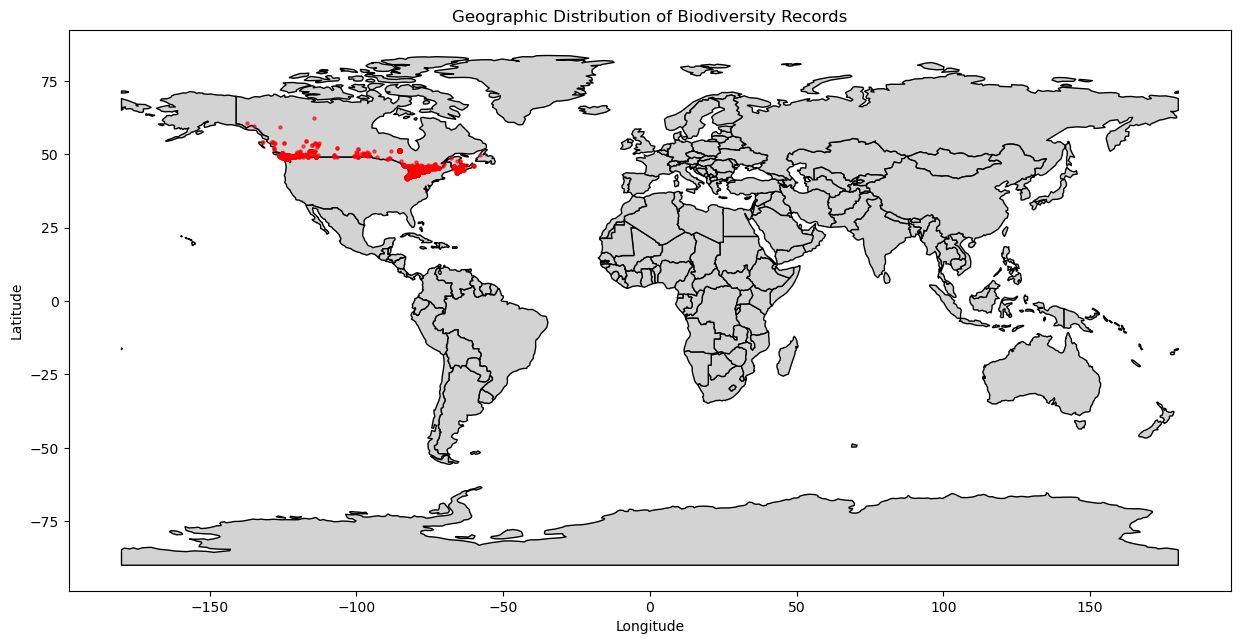

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# convert latitude and longitude to GeoDataFrame
geometry = [Point(xy) for xy in zip(biodiversity_data["longitude"], biodiversity_data["latitude"])]
geo_df = gpd.GeoDataFrame(biodiversity_data, geometry=geometry)

# load a world map for context
path_to_shapefile = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(path_to_shapefile)

# plot the data on the world map
plt.figure(figsize=(15, 10))
ax = world.plot(color='lightgray', edgecolor='black', figsize=(15, 10))
geo_df.plot(ax=ax, markersize=5, color='red', alpha=0.6)

plt.title("Geographic Distribution of Biodiversity Records")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Plot: Top 10 Most Observed Species

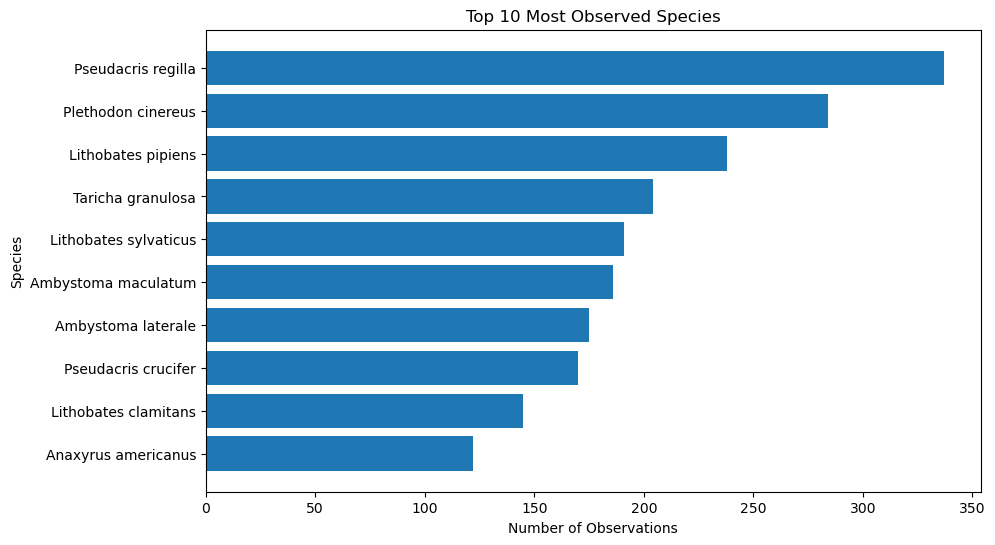

In [6]:
top_species = biodiversity_data["species"].value_counts().head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_species.index, top_species.values)
plt.title("Top 10 Most Observed Species")
plt.xlabel("Number of Observations")
plt.ylabel("Species")
plt.gca().invert_yaxis()
plt.show()

### Plot: Records Over Time for Top 5 Species

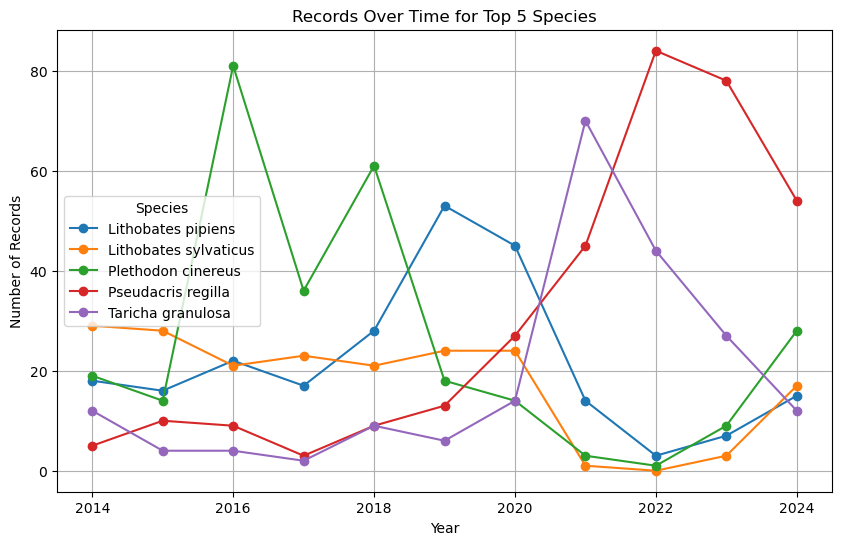

In [7]:
top_5_species = biodiversity_data["species"].value_counts().head(5).index
filtered_data = biodiversity_data[biodiversity_data["species"].isin(top_5_species)]
records_over_time = filtered_data.groupby(["Year", "species"]).size().unstack(fill_value=0)
records_over_time.plot(figsize=(10, 6), marker='o')
plt.title("Records Over Time for Top 5 Species")
plt.xlabel("Year")
plt.ylabel("Number of Records")
plt.legend(title="Species")
plt.grid(True)
plt.show()

## Costs of various conservation strategies over a four-year period

https://wwf.ca/wp-content/uploads/2020/12/PTM-EN-FINAL.pdf

In [8]:
import pandas as pd
import numpy as np

def simulate_conservation_costs():
    """
    Simulates conservation costs for 24 strategies over four years based on project areas and cost ranges.
    
    Each strategy has an associated project area (in hectares) and a cost range derived as ±20% of the actual cost.
    Simulated yearly costs are generated randomly within the specified range, scaled by the project area.

    Returns:
        pd.DataFrame: A DataFrame containing simulated conservation costs for each strategy over four years, 
                      along with project areas for reference.
    """
    # Define the 24 conservation strategies
    strategies = [f"Strategy {i}" for i in range(1, 25)]

    # Define the actual costs for each strategy (from earlier reference)
    actual_costs = [61405, 117807, 1039952, 1206655, 5462784, 19923782, 618660, 307654, 
                    505423, 130462, 40907, 17900, 962704, 184619, 263806, 437882, 
                    1219164, 7482514, 1628002, 5593246, 1285977, 11358618, 25819617]

    # Define cost range as ±20% of the actual cost
    cost_ranges = [(cost * 0.8, cost * 1.2) for cost in actual_costs]

    # Define project areas for each strategy (random values between 5 and 50 hectares)
    project_areas = np.random.randint(5, 50, size=len(strategies))

    # Initialize an empty list to store the simulated cost data
    cost_data = []

    # Generate costs for each strategy over ten years
    for strategy, area, (low, high) in zip(strategies, project_areas, cost_ranges):
        yearly_costs = {
            "Strategy": strategy,            # Conservation strategy name
            "Area (ha)": area,               # Project area in hectares
            "Year 1 Cost": round(area * np.random.uniform(low / area, high / area)),
            "Year 2 Cost": round(area * np.random.uniform(low / area, high / area)),
            "Year 3 Cost": round(area * np.random.uniform(low / area, high / area)),
            "Year 4 Cost": round(area * np.random.uniform(low / area, high / area)),
            "Year 5 Cost": round(area * np.random.uniform(low / area, high / area)),
            "Year 6 Cost": round(area * np.random.uniform(low / area, high / area)),
            "Year 7 Cost": round(area * np.random.uniform(low / area, high / area)),
            "Year 8 Cost": round(area * np.random.uniform(low / area, high / area)),
            "Year 9 Cost": round(area * np.random.uniform(low / area, high / area)),
            "Year 10 Cost": round(area * np.random.uniform(low / area, high / area))
        }
        cost_data.append(yearly_costs)

    # Convert the cost data to a DataFrame
    cost_df = pd.DataFrame(cost_data)

    return cost_df

### Plot: Total Cost by Strategy Over Ten Years

In [9]:
#simulate original conservation costs
conservation_costs = simulate_conservation_costs()

# recalculate total costs (ensure original units)
conservation_costs["Total Cost"] = (
    conservation_costs["Year 1 Cost"] + 
    conservation_costs["Year 2 Cost"] + 
    conservation_costs["Year 3 Cost"] + 
    conservation_costs["Year 4 Cost"] +
    conservation_costs["Year 5 Cost"] + 
    conservation_costs["Year 6 Cost"] + 
    conservation_costs["Year 7 Cost"] + 
    conservation_costs["Year 8 Cost"] + 
    conservation_costs["Year 9 Cost"] + 
    conservation_costs["Year 10 Cost"] 
)
conservation_costs.head()

,Strategy,Area (ha),Year 1 Cost,Year 2 Cost,Year 3 Cost,Year 4 Cost,Year 5 Cost,Year 6 Cost,Year 7 Cost,Year 8 Cost,Year 9 Cost,Year 10 Cost,Total Cost
0,Strategy 1,40,51170,68266,63922,67763,65640,72797,71420,59782,52429,66142,639331
1,Strategy 2,44,124121,124450,132691,116790,106761,110147,110751,123559,118169,121520,1188959
2,Strategy 3,25,1155573,996046,843582,1086565,1061394,894026,907352,1221000,1045987,1130873,10342398
3,Strategy 4,6,1210716,1012399,1402714,1193436,1339838,1011938,1347896,1176228,1384121,1377714,12457000
4,Strategy 5,23,4571360,5869014,4860642,5711170,6158214,5931975,4694877,5461071,5668306,6017576,54944205


In [10]:
print(conservation_costs.columns)


Index(['Strategy', 'Area (ha)', 'Year 1 Cost', 'Year 2 Cost', 'Year 3 Cost',
       'Year 4 Cost', 'Year 5 Cost', 'Year 6 Cost', 'Year 7 Cost',
       'Year 8 Cost', 'Year 9 Cost', 'Year 10 Cost', 'Total Cost'],
      dtype='object')


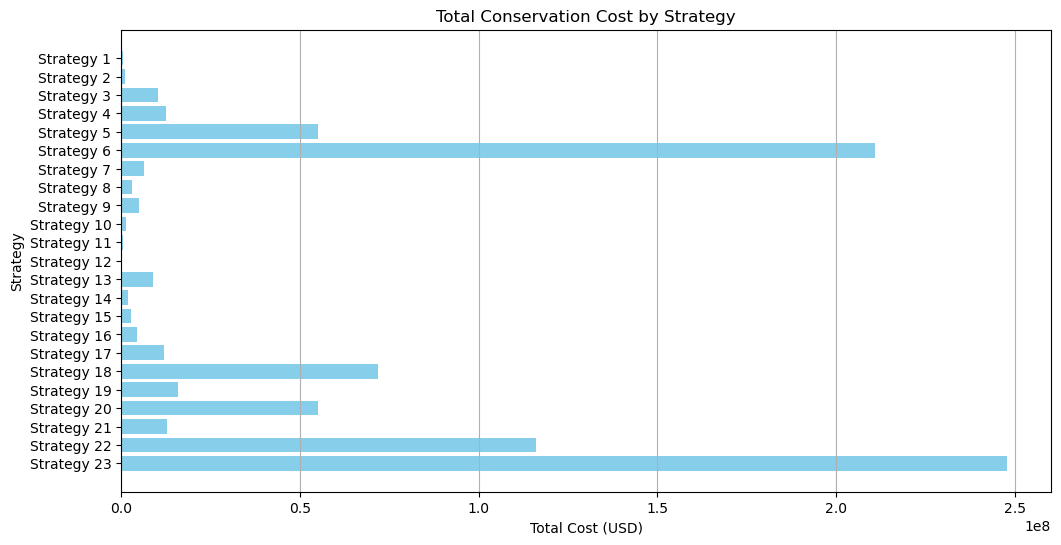

In [11]:
plt.figure(figsize=(12, 6))
plt.barh(conservation_costs["Strategy"], conservation_costs["Total Cost"], color='skyblue')
plt.title("Total Conservation Cost by Strategy")
plt.xlabel("Total Cost (USD)")
plt.ylabel("Strategy")
plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.show()

## Plot: Cost Breakdown by Year (Stacked Bar Chart)

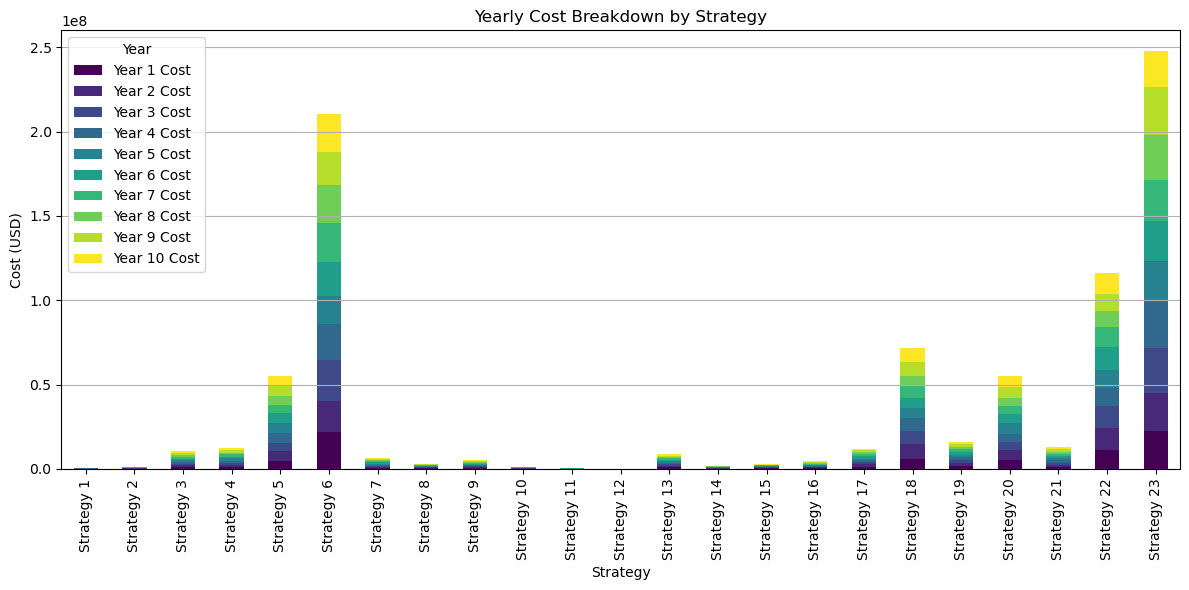

In [12]:
# Define the columns corresponding to yearly costs
yearly_columns = [
    "Year 1 Cost", "Year 2 Cost", "Year 3 Cost", "Year 4 Cost", 
    "Year 5 Cost", "Year 6 Cost", "Year 7 Cost", "Year 8 Cost", 
    "Year 9 Cost", "Year 10 Cost"
]

# Create the plot
conservation_costs.set_index("Strategy")[yearly_columns].plot(
    kind="bar", stacked=True, figsize=(12, 6), colormap="viridis"
)
plt.title("Yearly Cost Breakdown by Strategy")
plt.xlabel("Strategy")
plt.ylabel("Cost (USD)")
plt.legend(title="Year")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


### Plot: Average Yearly Cost by Strategy

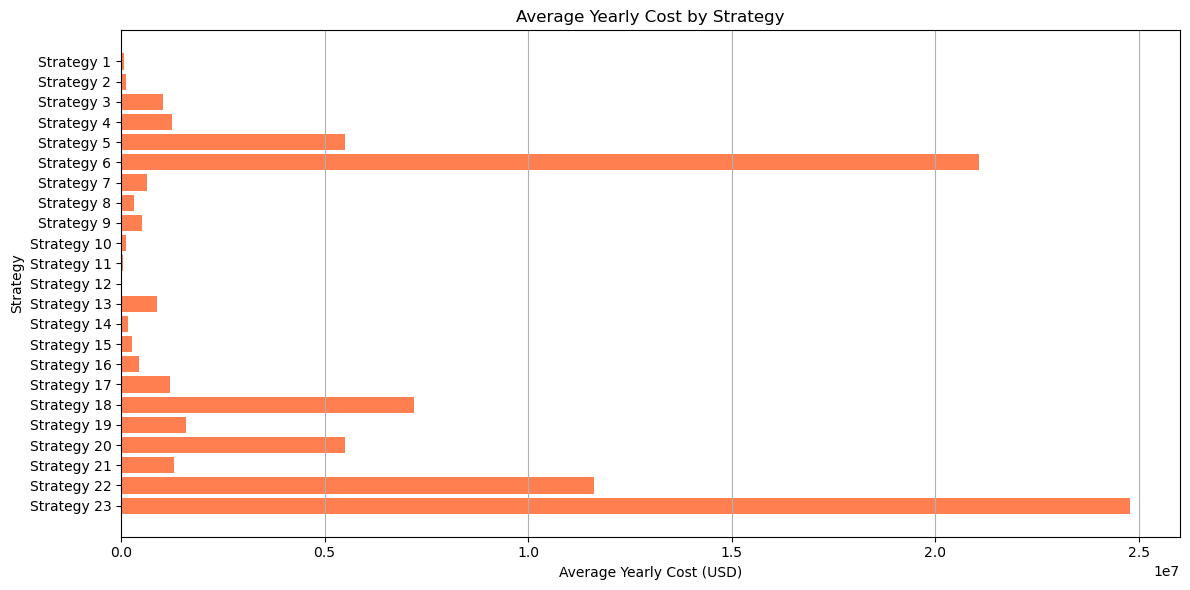

In [13]:
# Define the columns corresponding to yearly costs (if not already defined)
yearly_columns = [
    "Year 1 Cost", "Year 2 Cost", "Year 3 Cost", "Year 4 Cost", 
    "Year 5 Cost", "Year 6 Cost", "Year 7 Cost", "Year 8 Cost", 
    "Year 9 Cost", "Year 10 Cost"
]

# Calculate the average yearly cost
conservation_costs["Average Yearly Cost"] = conservation_costs[yearly_columns].mean(axis=1)

# Create the horizontal bar plot
plt.figure(figsize=(12, 6))
plt.barh(conservation_costs["Strategy"], conservation_costs["Average Yearly Cost"], color='coral')
plt.title("Average Yearly Cost by Strategy")
plt.xlabel("Average Yearly Cost (USD)")
plt.ylabel("Strategy")
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.grid(axis="x")
plt.tight_layout()
plt.show()


## Discount Factors

In [14]:
def generate_discount_factors(years, discount_rate):
    
    return [round((1 - discount_rate) ** year, 2) for year in range(years)]

# apply Discount Factors
def apply_discounts(cost_df, biodiversity_scores, discount_factors):
    
    for t in range(len(discount_factors)):
        biodiversity_score = biodiversity_scores.iloc[t]['Biodiversity_Score']
        cost_df[f"Year {t+1} Cost"] *= discount_factors[t]
        cost_df[f"Year {t+1} Impact"] = biodiversity_score * discount_factors[t]
    return cost_df

In [15]:
num_years = 10
discount_factors = generate_discount_factors(years=num_years, discount_rate=0.10)
print("\nDiscount Factors:")
print(discount_factors)

# apply Discounts
cost_df = apply_discounts(conservation_costs, biodiversity_scores, discount_factors)
print("\nDiscounted Costs and Impacts:")
cost_df.head()


Discount Factors:
[1.0, 0.9, 0.81, 0.73, 0.66, 0.59, 0.53, 0.48, 0.43, 0.39]

Discounted Costs and Impacts:


,Strategy,Area (ha),Year 1 Cost,Year 2 Cost,Year 3 Cost,Year 4 Cost,Year 5 Cost,Year 6 Cost,Year 7 Cost,Year 8 Cost,...,Year 1 Impact,Year 2 Impact,Year 3 Impact,Year 4 Impact,Year 5 Impact,Year 6 Impact,Year 7 Impact,Year 8 Impact,Year 9 Impact,Year 10 Impact
0,Strategy 1,40,51170.0,61439.4,51776.82,49466.99,43322.40,42950.23,37852.60,28695.36,...,163.5,146.7,131.22,102.565,108.9,97.35,86.125,78.48,69.23,63.96
1,Strategy 2,44,124121.0,112005.0,107479.71,85256.70,70462.26,64986.73,58698.03,59308.32,...,163.5,146.7,131.22,102.565,108.9,97.35,86.125,78.48,69.23,63.96
2,Strategy 3,25,1155573.0,896441.4,683301.42,793192.45,700520.04,527475.34,480896.56,586080.00,...,163.5,146.7,131.22,102.565,108.9,97.35,86.125,78.48,69.23,63.96
3,Strategy 4,6,1210716.0,911159.1,1136198.34,871208.28,884293.08,597043.42,714384.88,564589.44,...,163.5,146.7,131.22,102.565,108.9,97.35,86.125,78.48,69.23,63.96
4,Strategy 5,23,4571360.0,5282112.6,3937120.02,4169154.10,4064421.24,3499865.25,2488284.81,2621314.08,...,163.5,146.7,131.22,102.565,108.9,97.35,86.125,78.48,69.23,63.96


# Basic Optimization Model

In [16]:
from gurobipy import Model, GRB, quicksum

budgets = [50000, 60000, 70000, 80000, 50000, 60000, 70000, 80000, 50000, 60000]

model = Model("Conservation Optimization")
model.Params.OutputFlag = 0  

x = model.addVars(len(cost_df), num_years, vtype=GRB.BINARY, name="x")


for t in range(num_years):
    model.addConstr(x[5, t] + x[6, t] <= 1, name=f"Mutual_Exclusion_5_6_{t}")
    model.addConstr(x[6, t] + x[22, t] <= 1, name=f"Mutual_Exclusion_6_23_{t}")
    model.addConstr(x[1, t] + x[2, t] + x[3, t] == 3*x[17, t], name=f"Synergy_1_2_3_{t}")
    model.addConstr(x[4, t] + x[8, t] + x[9, t] == 3*x[18, t], name=f"Synergy_4_8_9_{t}")
    model.addConstr(x[10, t] + x[20, t] <= 1, name=f"Synergy_10_20_{t}")
    model.addConstr(x[13, t] + x[14, t] <= 1, name=f"Synergy_13_14_{t}")
    model.addConstr(x[15, t] + x[16, t] <= 1, name=f"Synergy_15_16_{t}")


for t in range(num_years):
        model.addConstr(
            quicksum(cost_df.loc[i, f"Year {t+1} Cost"] * x[i, t] for i in cost_df.index) <= budgets[t],
            name=f"Budget_Year_{t+1}"
        )


model.setObjective(
    quicksum(cost_df.loc[i, f"Year {t+1} Impact"] * x[i, t]
             for i in cost_df.index for t in range(num_years)),
    GRB.MAXIMIZE
)

model.optimize()

print("\nOptimal Strategies:")
for t in range(num_years):  
    print(f"\nYear {t+1}:")
    total_cost = 0
    total_impact = 0
    for i in cost_df.index:  
        if model.getVarByName(f"x[{i},{t}]").x > 0.5:  
            strategy_name = cost_df.loc[i, 'Strategy']
            cost = cost_df.loc[i, f"Year {t+1} Cost"]
            impact = cost_df.loc[i, f"Year {t+1} Impact"]
            total_cost += cost
            total_impact += impact
            print(f"  - {strategy_name}: Cost = {cost:.2f}, Impact = {impact:.2f}")
    print(f"  Total Cost: {total_cost:.2f}")
    print(f"  Total Biodiversity Impact: {total_impact:.2f}")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-05

Optimal Strategies:

Year 1:
  - Strategy 12: Cost = 21127.00, Impact = 163.50
  Total Cost: 21127.00
  Total Biodiversity Impact: 163.50

Year 2:
  - Strategy 11: Cost = 32856.30, Impact = 146.70
  - Strategy 12: Cost = 13628.70, Impact = 146.70
  Total Cost: 46485.00
  Total Biodiversity Impact: 293.40

Year 3:
  - Strategy 11: Cost = 34660.71, Impact = 131.22
  - Strategy 12: Cost = 11647.80, Impact = 131.22
  Total Cost: 46308.51
  Total Biodiversity Impact: 262.44

Year 4:
  - Strategy 1: Cost = 49466.99, Impact = 102.56
  - Strategy 11: Cost = 25601.10, Impact = 102.56
  Total Cost: 75068.09
  Total Biodiversity Impact: 205.13

Year 5:
  - Strategy 11: Cost = 28207.74, Impact = 108.90
  - Strategy 12: Cost = 10516.44, Impact = 108.90
  Total Cost: 38724.18
  Total Biodiversity Impact: 217.80

Year 6:
  - Strategy 1: Cost = 42950.23, Impact = 97.35
  - Strategy 12: Cost = 10003.45, Impact =

# Improved Optimization Model 1 

In [17]:
import numpy as np
from gurobipy import Model, GRB, quicksum


scenario_probabilities = [0.3, 0.5, 0.2]  
num_scenarios = len(scenario_probabilities)

# generate stochastic cost and impact data for each scenario
stochastic_costs = {s: cost_df[[f"Year {t+1} Cost" for t in range(num_years)]].apply(
    lambda x: x * np.random.uniform(0.8, 1.2, size=len(x)), axis=0) for s in range(num_scenarios)}

stochastic_impacts = {s: cost_df[[f"Year {t+1} Impact" for t in range(num_years)]].apply(
    lambda x: x * np.random.uniform(0.9, 1.1, size=len(x)), axis=0) for s in range(num_scenarios)}


model = Model("Stochastic Conservation Optimization")
model.Params.OutputFlag = 0  


x = model.addVars(len(cost_df), num_years, vtype=GRB.BINARY, name="x")


for t in range(num_years):
    model.addConstr(x[5, t] + x[6, t] <= 1, name=f"Mutual_Exclusion_5_6_{t}")
    model.addConstr(x[6, t] + x[22, t] <= 1, name=f"Mutual_Exclusion_6_23_{t}")
    model.addConstr(x[1, t] + x[2, t] + x[3, t] == 3*x[17, t], name=f"Synergy_1_2_3_{t}")
    model.addConstr(x[4, t] + x[8, t] + x[9, t] == 3*x[18, t], name=f"Synergy_4_8_9_{t}")
    model.addConstr(x[10, t] + x[20, t] <= 1, name=f"Synergy_10_20_{t}")
    model.addConstr(x[13, t] + x[14, t] <= 1, name=f"Synergy_13_14_{t}")
    model.addConstr(x[15, t] + x[16, t] <= 1, name=f"Synergy_15_16_{t}")

    for s in range(num_scenarios):
        model.addConstr(
            quicksum(stochastic_costs[s].iloc[i, t] * x[i, t] for i in cost_df.index) <= budgets[t],
            name=f"Budget_Scenario_{s}_Year_{t+1}"
        )

expected_impact = quicksum(
    scenario_probabilities[s] *
    quicksum(stochastic_impacts[s].iloc[i, t] * x[i, t]
             for i in cost_df.index for t in range(num_years))
    for s in range(num_scenarios)
)

model.setObjective(expected_impact, GRB.MAXIMIZE)

model.optimize()

# Output Results
print("\nOptimal Strategies:")
for t in range(num_years):
    print(f"\nYear {t+1}:")
    total_cost = 0
    total_impact = 0
    for i in cost_df.index:
        if model.getVarByName(f"x[{i},{t}]").x > 0.5:
            strategy_name = cost_df.loc[i, 'Strategy']
            cost = sum(stochastic_costs[s].iloc[i, t] * scenario_probabilities[s] for s in range(num_scenarios))
            impact = sum(stochastic_impacts[s].iloc[i, t] * scenario_probabilities[s] for s in range(num_scenarios))
            total_cost += cost
            total_impact += impact
            print(f"  - {strategy_name}: Expected Cost = {cost:.2f}, Expected Impact = {impact:.2f}")
    print(f"  Total Expected Cost: {total_cost:.2f}")
    print(f"  Total Expected Biodiversity Impact: {total_impact:.2f}")


Optimal Strategies:

Year 1:
  - Strategy 12: Expected Cost = 22511.01, Expected Impact = 167.41
  Total Expected Cost: 22511.01
  Total Expected Biodiversity Impact: 167.41

Year 2:
  - Strategy 11: Expected Cost = 31047.38, Expected Impact = 136.00
  - Strategy 12: Expected Cost = 14814.71, Expected Impact = 150.86
  Total Expected Cost: 45862.09
  Total Expected Biodiversity Impact: 286.86

Year 3:
  - Strategy 11: Expected Cost = 37317.50, Expected Impact = 135.78
  - Strategy 12: Expected Cost = 11970.60, Expected Impact = 123.20
  Total Expected Cost: 49288.10
  Total Expected Biodiversity Impact: 258.98

Year 4:
  - Strategy 1: Expected Cost = 47799.17, Expected Impact = 103.25
  - Strategy 11: Expected Cost = 24132.88, Expected Impact = 108.00
  Total Expected Cost: 71932.05
  Total Expected Biodiversity Impact: 211.25

Year 5:
  - Strategy 11: Expected Cost = 28255.85, Expected Impact = 107.64
  - Strategy 12: Expected Cost = 9765.96, Expected Impact = 109.67
  Total Expected

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

results = []
for t in range(num_years):
    for i in cost_df.index:
        if model.getVarByName(f"x[{i},{t}]").x > 0.5:
            strategy_name = cost_df.loc[i, 'Strategy']
            expected_cost = sum(stochastic_costs[s].iloc[i, t] * scenario_probabilities[s] for s in range(num_scenarios))
            expected_impact = sum(stochastic_impacts[s].iloc[i, t] * scenario_probabilities[s] for s in range(num_scenarios))
            results.append({
                'Year': t + 1,
                'Strategy': strategy_name,
                'Expected Cost': expected_cost,
                'Expected Impact': expected_impact
            })

results_df = pd.DataFrame(results)

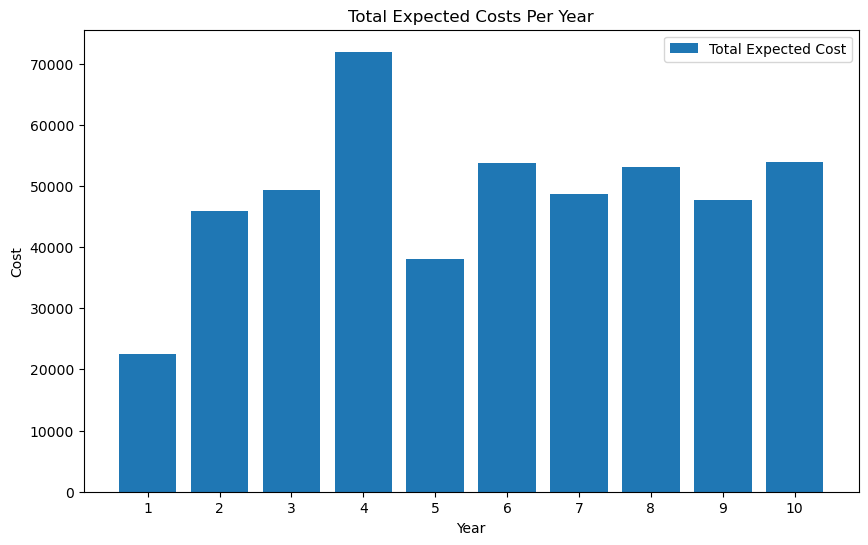

In [19]:
yearly_totals = results_df.groupby('Year').sum()

plt.figure(figsize=(10, 6))
plt.bar(yearly_totals.index, yearly_totals['Expected Cost'], label='Total Expected Cost')
plt.title('Total Expected Costs Per Year')
plt.xlabel('Year')
plt.ylabel('Cost')
plt.xticks(yearly_totals.index)
plt.legend()
plt.show()

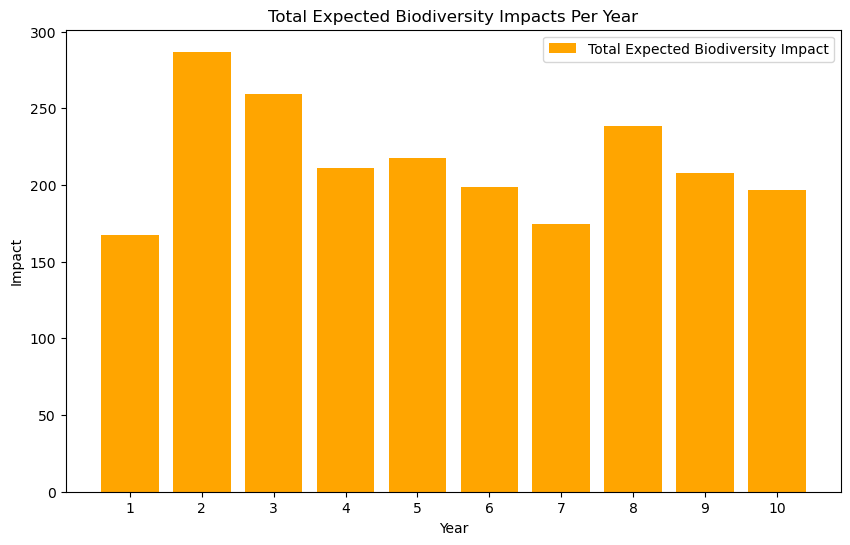

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(yearly_totals.index, yearly_totals['Expected Impact'], label='Total Expected Biodiversity Impact', color='orange')
plt.title('Total Expected Biodiversity Impacts Per Year')
plt.xlabel('Year')
plt.ylabel('Impact')
plt.xticks(yearly_totals.index)
plt.legend()
plt.show()

# Improved Optimization Model 2 

In [21]:
def plot_pareto_front(costs, impacts):
    
    data = pd.DataFrame({"Cost": costs, "Impact": impacts})
    data = data.sort_values(by="Cost").reset_index(drop=True)

    pareto_front = [data.iloc[0]]  
    for i in range(1, len(data)):
        if data.iloc[i]["Impact"] > pareto_front[-1]["Impact"]:
            pareto_front.append(data.iloc[i])
    pareto_front = pd.DataFrame(pareto_front)

    plt.figure(figsize=(10, 6))
    plt.scatter(data["Cost"], data["Impact"], color='blue', label='All Strategies')

    plt.plot(pareto_front["Cost"], pareto_front["Impact"], 'r-', label='Pareto Front')

    plt.title("Pareto Front: Cost-Impact Trade-offs")
    plt.xlabel("Total Cost")
    plt.ylabel("Total Biodiversity Impact")
    plt.legend()
    plt.grid()
    plt.show()


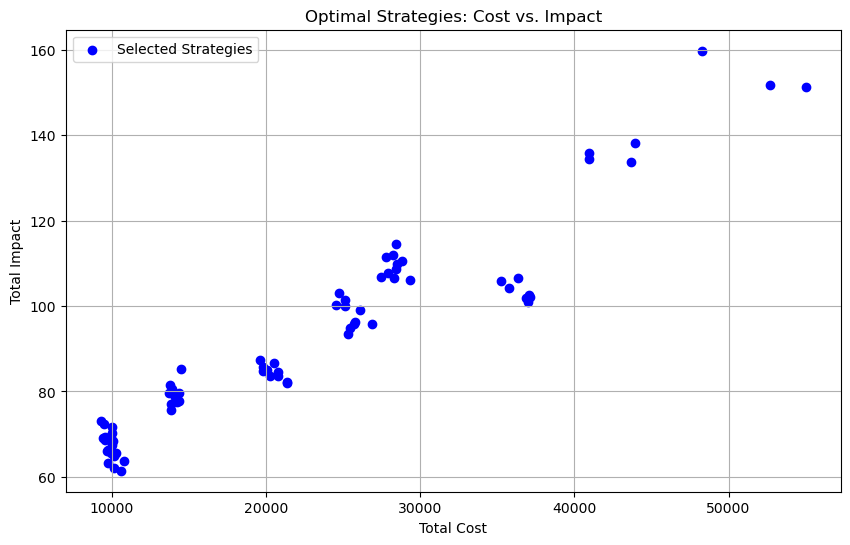

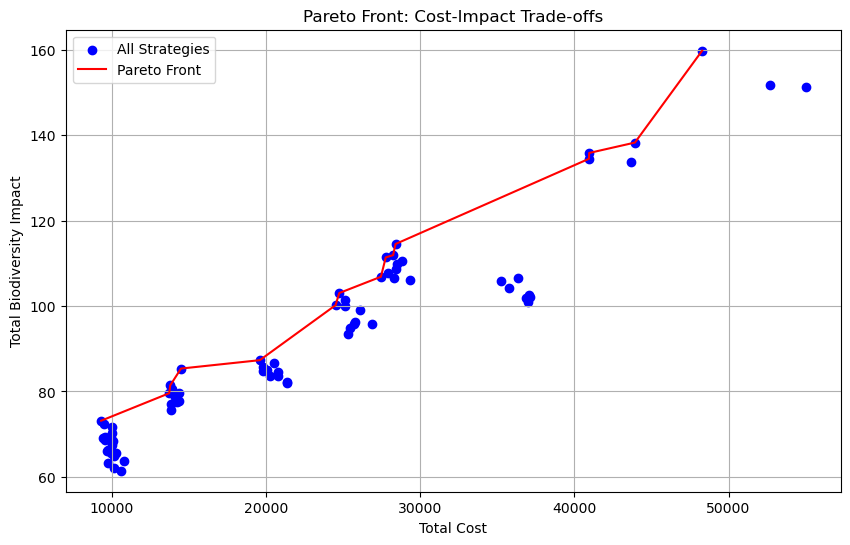

In [22]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

np.random.seed(42)

# Enhanced stochastic modeling
def generate_stochastic_scenarios(cost_df, biodiversity_scores, discount_factors, num_scenarios, variability=0.2):
    
    stochastic_costs = []
    stochastic_impacts = []

    for _ in range(num_scenarios):
        scenario_cost_df = cost_df.copy()
        for t in range(len(discount_factors)):
            random_cost_factor = np.random.normal(1, variability, size=cost_df.shape[0])
            random_impact_factor = np.random.normal(1, variability, size=cost_df.shape[0])
            
            scenario_cost_df[f"Year {t+1} Cost"] *= discount_factors[t] * random_cost_factor
            scenario_cost_df[f"Year {t+1} Impact"] = biodiversity_scores.iloc[t]["Biodiversity_Score"] * discount_factors[t] * random_impact_factor
        
        stochastic_costs.append(scenario_cost_df[[f"Year {t+1} Cost" for t in range(len(discount_factors))]])
        stochastic_impacts.append(scenario_cost_df[[f"Year {t+1} Impact" for t in range(len(discount_factors))]])

    return stochastic_costs, stochastic_impacts

def reduce_scenarios(stochastic_costs, stochastic_impacts, num_clusters):
   
    cost_data = np.vstack([cost.values.flatten() for cost in stochastic_costs])
    impact_data = np.vstack([impact.values.flatten() for impact in stochastic_impacts])
    
   
    combined_data = np.hstack([cost_data, impact_data])
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(combined_data)
    cluster_centers = kmeans.cluster_centers_
    
    reduced_costs = pd.DataFrame(cluster_centers[:, :cost_data.shape[1]].reshape(num_clusters, -1))
    reduced_impacts = pd.DataFrame(cluster_centers[:, cost_data.shape[1]:].reshape(num_clusters, -1))
    
    return reduced_costs, reduced_impacts

def build_optimization_model(reduced_costs, reduced_impacts, num_years, num_clusters, budgets):
    
    model = Model("Enhanced Conservation Optimization")
    model.Params.OutputFlag = 0  

    x = model.addVars(len(reduced_costs), num_years, vtype=GRB.BINARY, name="x")

    model.setObjective(
        quicksum(
            reduced_impacts.loc[i, t] * x[i, t]
            for i in reduced_costs.index
            for t in range(num_years)
        ) / num_clusters,
        GRB.MAXIMIZE
    )

    cumulative_budget = 0
    for t in range(num_years):
        cumulative_budget += budgets[t]
        model.addConstr(
            quicksum(reduced_costs.loc[i, t] * x[i, t] for i in reduced_costs.index) <= cumulative_budget,
            name=f"Budget_Year_{t+1}"
        )

    model.optimize()
    return model

def visualize_results(model, reduced_costs, reduced_impacts, num_years):
    
    optimal_costs = []
    optimal_impacts = []
    
    for t in range(num_years):
        for i in reduced_costs.index:
            if model.getVarByName(f"x[{i},{t}]").x > 0.5:
                cost = reduced_costs.iloc[i, t]
                impact = reduced_impacts.iloc[i, t]
                optimal_costs.append(cost)
                optimal_impacts.append(impact)

    plt.figure(figsize=(10, 6))
    plt.scatter(optimal_costs, optimal_impacts, color='blue', label='Selected Strategies')
    plt.title("Optimal Strategies: Cost vs. Impact")
    plt.xlabel("Total Cost")
    plt.ylabel("Total Impact")
    plt.legend()
    plt.grid()
    plt.show()

def main():
    
    num_years = 10
    num_scenarios = 500
    num_clusters = 10
    budgets = [50000, 60000, 70000, 80000, 50000, 60000, 70000, 80000, 50000, 60000]


    discount_factors = [1.0, 0.9, 0.81, 0.73, 0.66, 0.59, 0.53, 0.48, 0.43, 0.39]
    stochastic_costs, stochastic_impacts = generate_stochastic_scenarios(
        cost_df, biodiversity_scores, discount_factors, num_scenarios, variability=0.2
    )
    
    reduced_costs, reduced_impacts = reduce_scenarios(stochastic_costs, stochastic_impacts, num_clusters)

    model = build_optimization_model(reduced_costs, reduced_impacts, num_years, num_clusters, budgets)
    visualize_results(model, reduced_costs, reduced_impacts, num_years)

    
    optimal_costs = [reduced_costs.iloc[i, t] for t in range(num_years) for i in reduced_costs.index if model.getVarByName(f"x[{i},{t}]").x > 0.5]
    optimal_impacts = [reduced_impacts.iloc[i, t] for t in range(num_years) for i in reduced_impacts.index if model.getVarByName(f"x[{i},{t}]").x > 0.5]
    
    plot_pareto_front(optimal_costs, optimal_impacts)

if __name__ == "__main__":
    main()


APPENDIX - SENSITIVITY ANALYSIS OF PARETO FRONT

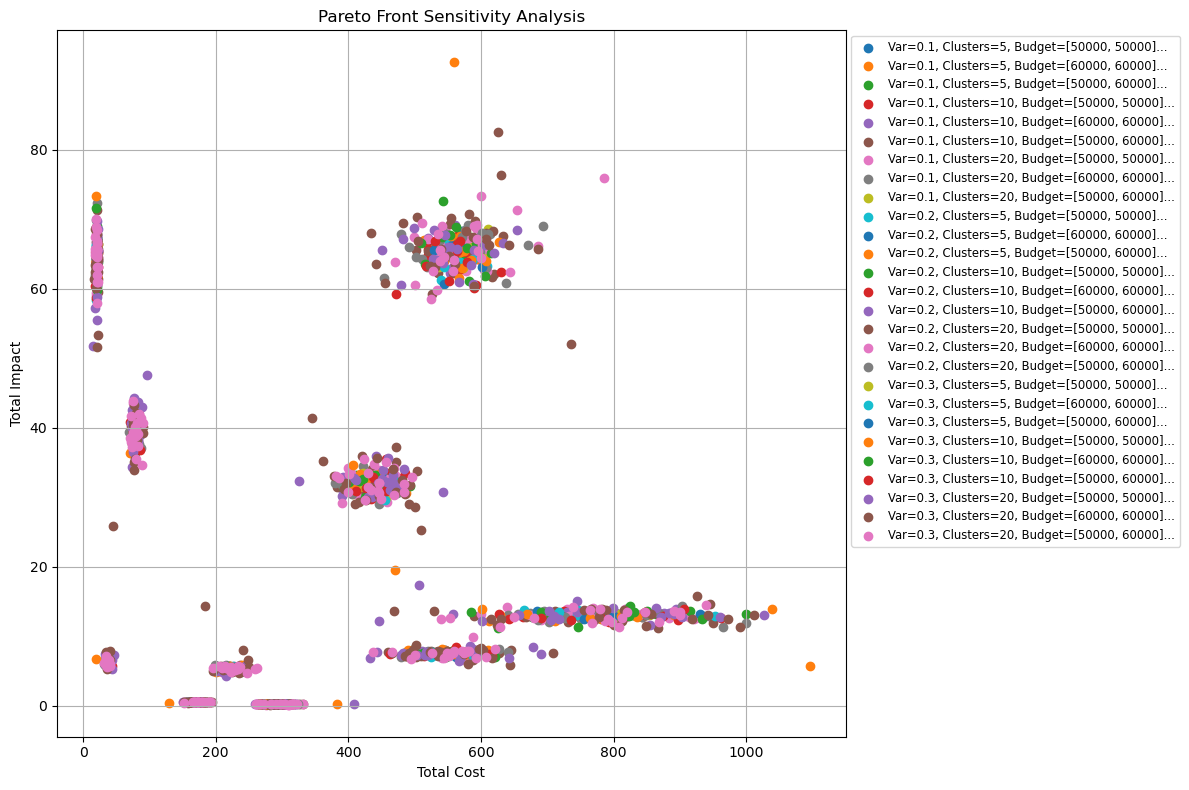

In [23]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

np.random.seed(42)

def generate_stochastic_scenarios(cost_df, biodiversity_scores, discount_factors, num_scenarios, variability=0.2):
    stochastic_costs = []
    stochastic_impacts = []

    for _ in range(num_scenarios):
        scenario_cost_df = cost_df.copy()
        for t in range(len(discount_factors)):
            random_cost_factor = np.random.normal(1, variability, size=cost_df.shape[0])
            random_impact_factor = np.random.normal(1, variability, size=cost_df.shape[0])
            
            scenario_cost_df[f"Year {t+1} Cost"] *= discount_factors[t] * random_cost_factor
            scenario_cost_df[f"Year {t+1} Impact"] = biodiversity_scores.iloc[t]["Biodiversity_Score"] * discount_factors[t] * random_impact_factor
        
        stochastic_costs.append(scenario_cost_df[[f"Year {t+1} Cost" for t in range(len(discount_factors))]])
        stochastic_impacts.append(scenario_cost_df[[f"Year {t+1} Impact" for t in range(len(discount_factors))]])

    return stochastic_costs, stochastic_impacts

def reduce_scenarios(stochastic_costs, stochastic_impacts, num_clusters):
    cost_data = np.vstack([cost.values.flatten() for cost in stochastic_costs])
    impact_data = np.vstack([impact.values.flatten() for impact in stochastic_impacts])
    
    combined_data = np.hstack([cost_data, impact_data])
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(combined_data)
    cluster_centers = kmeans.cluster_centers_
    
    reduced_costs = pd.DataFrame(cluster_centers[:, :cost_data.shape[1]].reshape(num_clusters, -1))
    reduced_impacts = pd.DataFrame(cluster_centers[:, cost_data.shape[1]:].reshape(num_clusters, -1))
    
    return reduced_costs, reduced_impacts

def build_optimization_model(reduced_costs, reduced_impacts, num_years, num_clusters, budgets):
    model = Model("Conservation Optimization")
    model.Params.OutputFlag = 0  # Suppress solver output

    x = model.addVars(len(reduced_costs), num_years, vtype=GRB.BINARY, name="x")

    model.setObjective(
        quicksum(
            reduced_impacts.loc[i, t] * x[i, t]
            for i in reduced_costs.index
            for t in range(num_years)
        ) / num_clusters,
        GRB.MAXIMIZE
    )

    cumulative_budget = 0
    for t in range(num_years):
        cumulative_budget += budgets[t]
        model.addConstr(
            quicksum(reduced_costs.loc[i, t] * x[i, t] for i in reduced_costs.index) <= cumulative_budget,
            name=f"Budget_Year_{t+1}"
        )

    model.optimize()
    return model

def plot_pareto_front(costs, impacts, label):
    plt.scatter(costs, impacts, label=label)

def main_sensitivity_analysis(cost_df, biodiversity_scores):
    num_years = 10
    num_scenarios = 500
    discount_factors = [1.0, 0.9, 0.81, 0.73, 0.66, 0.59, 0.53, 0.48, 0.43, 0.39]

    variabilities = [0.1, 0.2, 0.3]
    cluster_counts = [5, 10, 20]
    budget_scenarios = [
        [50000] * num_years,
        [60000] * num_years,
        [50000, 60000, 70000, 80000, 50000, 60000, 70000, 80000, 50000, 60000]
    ]

    plt.figure(figsize=(12, 8))
    for variability in variabilities:
        for num_clusters in cluster_counts:
            for budgets in budget_scenarios:
                stochastic_costs, stochastic_impacts = generate_stochastic_scenarios(
                    cost_df, biodiversity_scores, discount_factors, num_scenarios, variability
                )
                reduced_costs, reduced_impacts = reduce_scenarios(stochastic_costs, stochastic_impacts, num_clusters)

                model = build_optimization_model(reduced_costs, reduced_impacts, num_years, num_clusters, budgets)

                optimal_costs = [
                    reduced_costs.iloc[i, t]
                    for t in range(num_years)
                    for i in reduced_costs.index
                    if model.getVarByName(f"x[{i},{t}]").x > 0.5
                ]
                optimal_impacts = [
                    reduced_impacts.iloc[i, t]
                    for t in range(num_years)
                    for i in reduced_impacts.index
                    if model.getVarByName(f"x[{i},{t}]").x > 0.5
                ]

                label = f"Var={variability}, Clusters={num_clusters}, Budget={budgets[:2]}..."
                plot_pareto_front(optimal_costs, optimal_impacts, label)

    plt.title("Pareto Front Sensitivity Analysis")
    plt.xlabel("Total Cost")
    plt.ylabel("Total Impact")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize='small')
    plt.grid()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    cost_df = pd.DataFrame({"Strategy": [f"Strategy {i+1}" for i in range(10)]})
    biodiversity_scores = pd.DataFrame({"Biodiversity_Score": np.random.rand(10)})
    
    for t in range(10):
        cost_df[f"Year {t+1} Cost"] = np.random.rand(10) * 1000
        biodiversity_scores = biodiversity_scores.assign(Biodiversity_Score=np.random.rand(10) * 100)
    
    main_sensitivity_analysis(cost_df, biodiversity_scores)


In [ ]:
biodiversity_data.to_csv("biodiversity_data.csv", index=False)

biodiversity_data.to_excel("biodiversity_data.xlsx", index=False)

